# (Re)Introduction to Image Processing

**Version 0.1**

During Session 1 of the DSFP, Robert Lupton provided a problem that brilliantly introduced some of the basic challenges associated with measuring the flux of a point source. As such, we will revisit that problem as a review/introduction to the remainder of the week.

* * *

By AA Miller (CIERA/Northwestern & Adler) <br>
[But please note that this is essentially a copy of Robert's lecture.]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

## Problem 1) An (oversimplified) 1-D Model

For this introductory problem we are going to simulate a 1 dimensional detector (the more complex issues associated will real stars on 2D detectors will be covered tomorrow by Dora). We will generate stars as Gaussians $N(\mu, \sigma^2)$, with mean $\mu$ and variance $\sigma^2$.

As observed by LSST, all stars are point sources that reflect the point spread function (PSF), which is produced by a combination of the atmosphere, telescope, and detector. A standard measure of the PSF's width is the Full Width Half Maximum (FWHM). 

There is also a smooth background of light from several sources that I previously mentioned (the atmosphere, the detector, etc). We will refer to this background simply as "The Sky".

**Problem 1a**

Write a function `phi()` to simulate a (noise-free) 1D Gaussian PSF. The function should take `mu` and `fwhm` as arguments, and evaluate the PSF along a user-supplied array `x`.

*Hint* - for a Gaussian $N(0, \sigma^2)$, the FWHM is $2\sqrt{2\ln(2)}\,\sigma \approx 2.3548\sigma$.

In [2]:
def phi(x, mu, fwhm):
    """Evalute the 1d PSF N(mu, sigma^2) along x"""
    sigma = fwhm/2.3548
    flux = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x - mu)**2/(2*sigma**2))
    return flux

**Problem 1b**

Plot the noise-free PSF for a star with $\mu = 10$ and $\mathrm{FWHM} = 3$. What is the flux of this star?

<IPython.core.display.Javascript object>


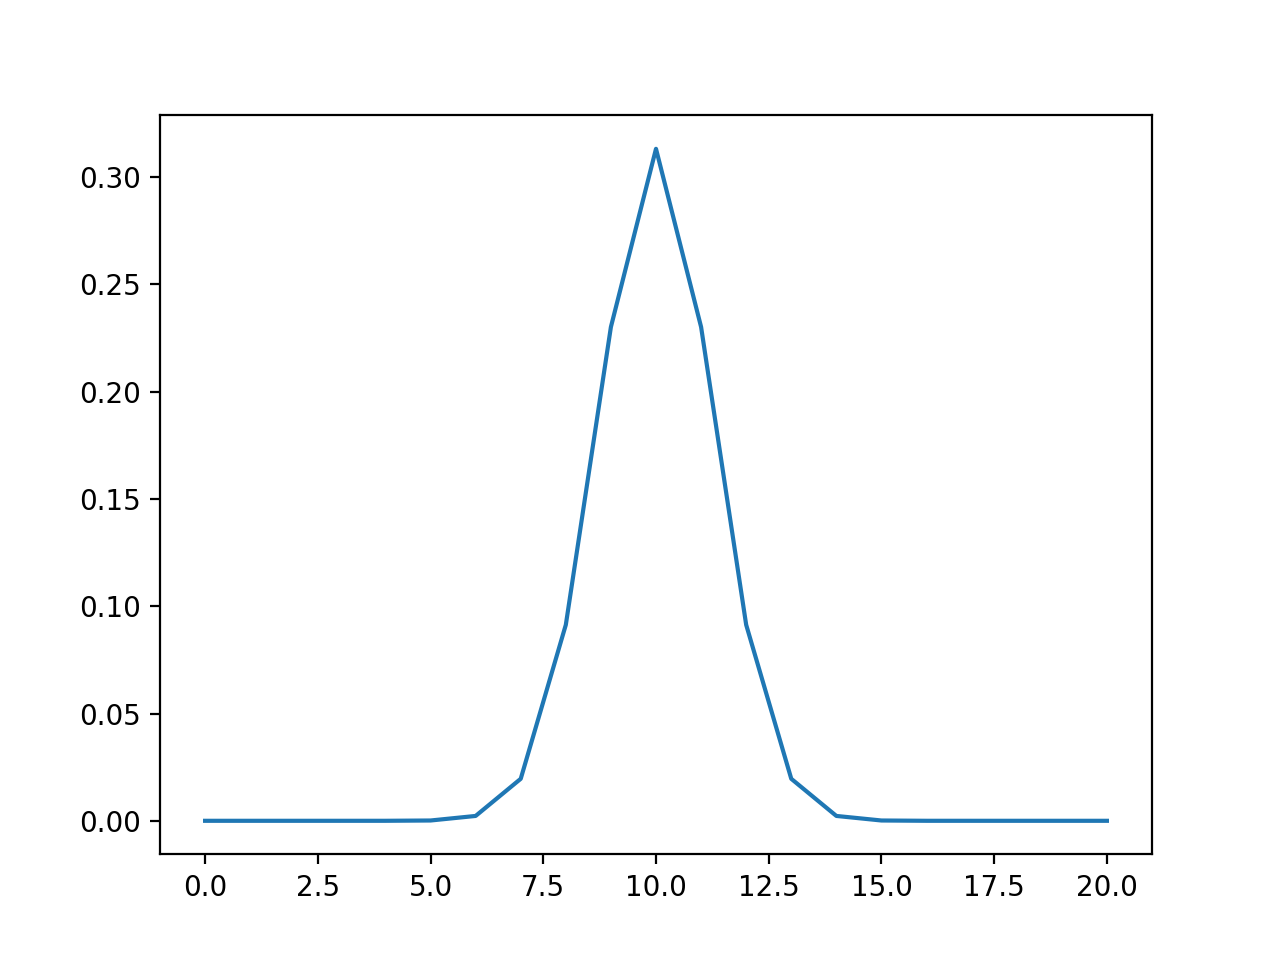

The flux of the star is: 1.000


In [67]:
x = np.linspace(0,20,21)

plt.plot(x, phi(x, 10, 3))

print("The flux of the star is: {:.3f}".format(sum(phi(x, 10, 3))))

**Problem 1c**

Add Sky noise (a constant in this case) to your model. Define the sky as `S`, with total stellar flux `F`.

Plot the model for `S` = 100 and `F` = 500. 

<IPython.core.display.Javascript object>


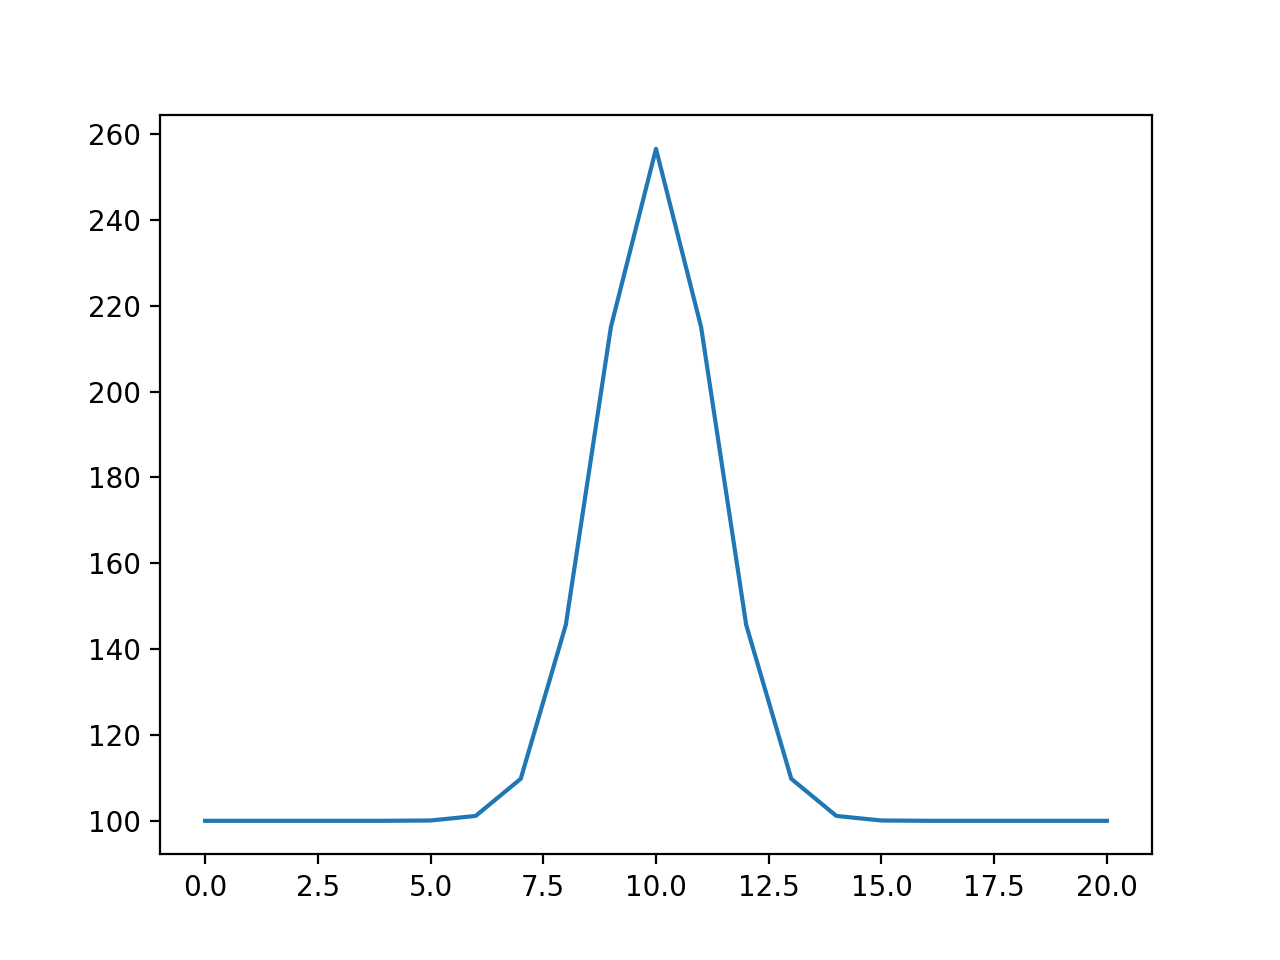

In [68]:
S = 100 * np.ones_like(x)
F = 500

plt.plot(x, S + F*phi(x, 10, 3))

## Problem 2) Add Noise

We will add noise to this simulation assuming that photon counting contributes the only source of uncertainty (this assumption is far from sufficient in real life). Within each pixel, $n$ photons are detected with an uncertainty that follows a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), which has the property that the mean $\mu$ is equal to the variance $\mu$. If $n \gg 1$ then $P(\mu) \approx N(\mu, \mu)$ [you can safely assume we will be in this regime for the remainder of this problem].

**Problem 2a**

Calculate the noisy flux for the simulated star in Problem 1c.

*Hint* - you may find the function [`np.random.normal()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.normal.html) helpful.

In [69]:
no_noise = S + F*phi(x, 10, 3)
noisy_flux = np.random.normal(no_noise, np.sqrt(no_noise))

**Problem 2b**

Overplot the noisy signal, with the associated uncertainties, on top of the noise-free signal.

<IPython.core.display.Javascript object>


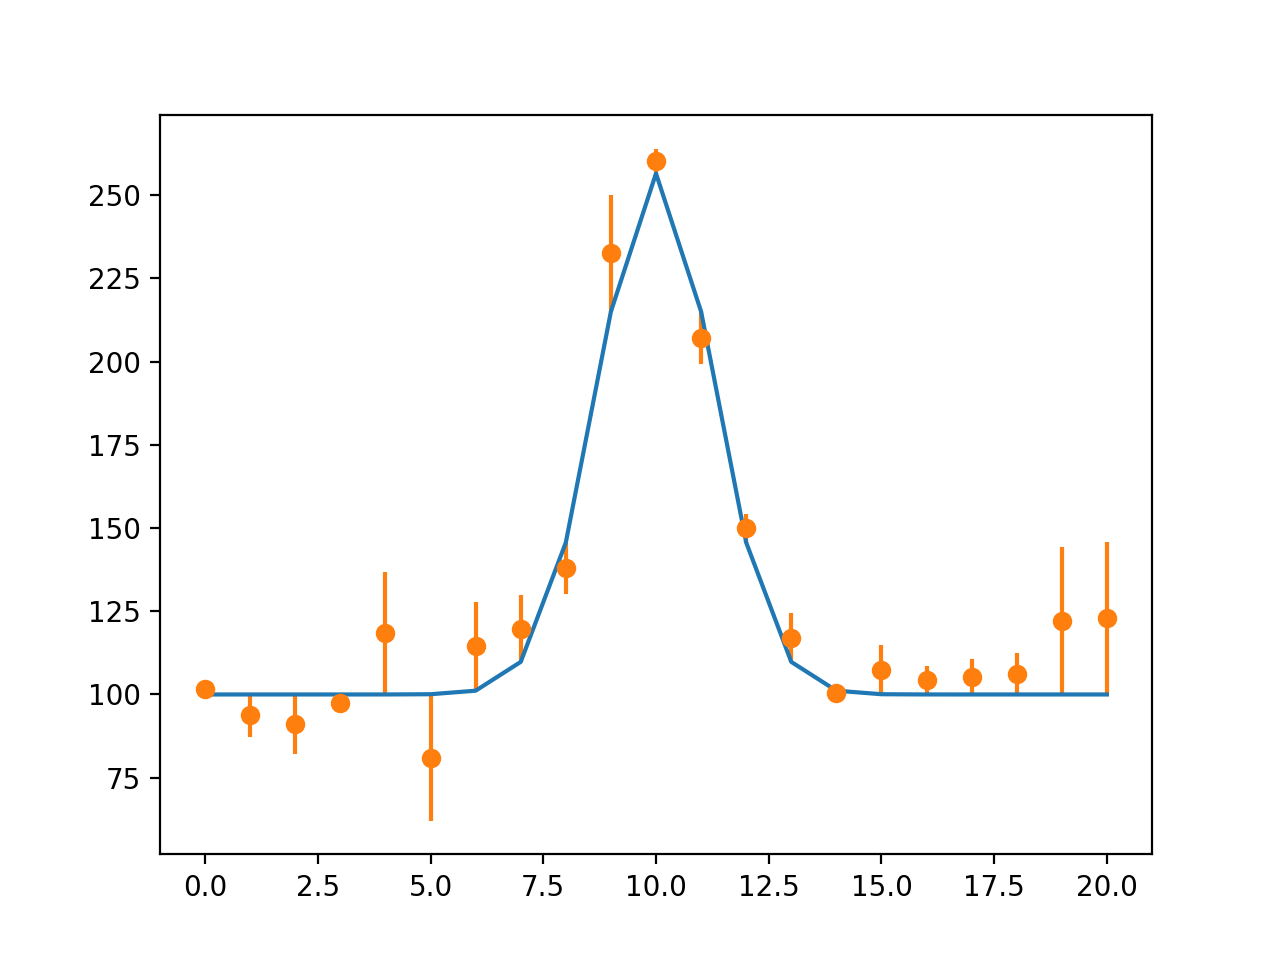

<Container object of 3 artists>

In [70]:
plt.plot(x, no_noise)
plt.errorbar(x, noisy_flux, noisy_flux - no_noise, fmt = 'o')

## Problem 3) Flux Measurement

We will now attempt to measure the flux from a simulated star. 

**Problem 3a**

Write a function `simulate()` to simulate the noisy flux measurements of a star with centroid `mu`, FWHM `fwhm`, sky background `S`, and flux `F`.

*Hint* - it may be helpful to plot the output of your function.

In [19]:
def simulate(x, mu, fwhm, S, F):
    source = F * phi(x, mu, fwhm)
    sky_plus_source = S * np.ones_like(x) + source
    noisy_flux = np.random.normal(sky_plus_source, np.sqrt(sky_plus_source))
    
    return noisy_flux

**Problem 3b** 

Using an aperture with radius of 5 pixels centered on the source, measure the flux from a star centered at `mu` = 0, with `fwhm` = 5, `S` = 100, and `F` = 1000.

*Hint* - assume you can perfectly measure the background, and subtract this prior to the measurement.

In [73]:
x = np.linspace(-20,20,41)
sim_star = simulate(x, 0, 5, 100, 1000)

ap_flux = np.sum((sim_star - 100)[np.where(np.abs(x) <= 5)])

print("The star has flux = {:.3f}".format(ap_flux))

The star has flux = 956.399


**Problem 3c** 

Write a Monte Carlo simulator to estimate the mean and standard deviation of the flux from the simulated star.

*Food for thought* - what do you notice if you run your simulator many times?

In [78]:
sim_fluxes = np.empty(1000)
for sim_num, dummy in enumerate(sim_fluxes):
    sim_star = simulate(x, 0, 5, 100, 1000)
    ap_flux = np.sum((sim_star - 100)[np.where(np.abs(x) <= 5)])
    
    sim_fluxes[sim_num] = ap_flux

print("The mean flux = {:.3f} with variance = {:.3f}".format(np.mean(sim_fluxes),
                                                             np.var(sim_fluxes, ddof=1)))

The mean flux = 991.795 with variance = 2211.481


## Problem 4) PSF Flux measurement

In this problem we are going to use our knowledge of the PSF to estimate the flux of the star. We will compare these measurements to the aperture flux measurements above.

**Problem 4a**

Create the psf model, `psf`, which is equivalent to a noise-free star with `fwhm` = 5.

In [58]:
psf = phi(x, 0, 5)

psf /= sum(psf**2) # normalization

**Problem 4b** 

Using the same parameters as problem 3, simulate a star and measure it's PSF flux.

In [59]:
sim_star = simulate(x, 0, 5, 100, 1000)

psf_flux = np.sum((sim_star-100)*psf)

print("The PSF flux is {:.3f}".format(psf_flux))

The PSF flux is 1023.051


**Problem 4c**

As before, write a Monte Carlo simulator to estimate the PSF flux of the star. How do your results compare to above?

In [64]:
sim_fluxes = np.empty(1000)
for sim_num, dummy in enumerate(sim_fluxes):
    sim_star = simulate(x, 0, 5, 100, 1000)
    psf_flux = np.sum((sim_star-100)*psf)
    
    sim_fluxes[sim_num] = psf_flux

print("The mean flux = {:.3f} with variance = {:.3f}".format(np.mean(sim_fluxes),
                                                             np.var(sim_fluxes, ddof=1)))

The mean flux = 1000.716 with variance = 1899.711


## Challenge Problem

**Problem C1**

Simulate several stars with flux `F` and measure their flux to determine the "detection limit" relative to a sky brightness `S`. 

**Problem C2**

Simulate multiple stars and determine the minimum separation for which multiple stars can be detected as a function of FWHM. Is this only a function of FHWM?